In [1]:
#importing the libraries
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#getting the kaggle dataset
dataset = pd.read_csv('digit-recognizer/train.csv')

In [3]:
#preprocessing the dataset
from keras.utils import np_utils
x_data,y_data = dataset[dataset.columns[1:]],dataset[dataset.columns[0]]
x_data = x_data.values.reshape(x_data.shape[0],28,28,1)
num_class = len(np.unique(y_data))
y_data = np_utils.to_categorical(y_data,num_class)

In [4]:
#splliting the dataset into train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = 42)

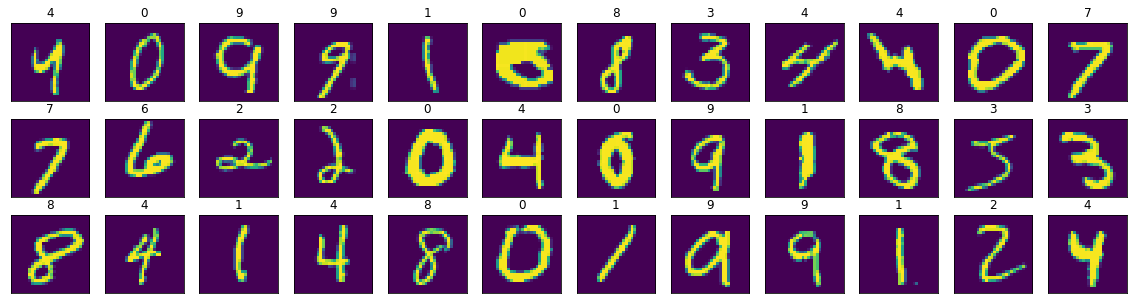

In [5]:
#plotting the dataset
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title((np.where(y_train[i] == 1))[0][0])

In [6]:
#spllting the dataset into train and validation set
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]


In [7]:
#the model architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1569000   
__________

In [8]:
#model compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

In [9]:
hist = model.fit(x_train, y_train, batch_size=1200, epochs=30,validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Train on 24400 samples, validate on 5000 samples
Epoch 1/30
24400/24400 [==============================] - 11s 446us/step - loss: 12.1012 - acc: 0.2387 - val_loss: 11.6808 - val_acc: 0.2736

Epoch 00001: val_loss improved from inf to 11.68083, saving model to model.weights.best.hdf5
Epoch 2/30
24400/24400 [==============================] - 5s 214us/step - loss: 11.5248 - acc: 0.2838 - val_loss: 11.6318 - val_acc: 0.2776

Epoch 00002: val_loss improved from 11.68083 to 11.63182, saving model to model.weights.best.hdf5
Epoch 3/30
24400/24400 [==============================] - 5s 213us/step - loss: 11.4802 - acc: 0.2868 - val_loss: 11.6054 - val_acc: 0.2790

Epoch 00003: val_loss improved from 11.63182 to 11.60540, saving model to model.weights.best.hdf5
Epoch 4/30
24400/24400 [==============================] - 5s 213us/step - loss: 11.4719 - acc: 0.2873 - val_loss: 11.5994 - val_acc: 0.2794

Epoch 00004: val_loss improved from 11.60540 to 11.59944, saving model to model.weights.best.hdf5

In [10]:
#load best weights and predict
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9866666666666667


In [11]:
#load the test data
sub_data = pd.read_csv('digit-recognizer/test.csv')
sub_data = sub_data.values.reshape(sub_data.shape[0],28,28,1)

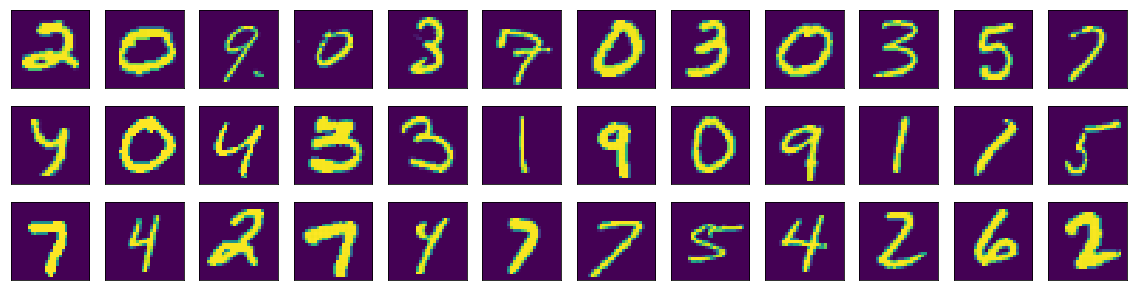

In [12]:
#plot the test data
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(sub_data[i]))

In [13]:
#predict for the test dataset
pred = model.predict_classes(sub_data)

In [14]:
#generate the final prediction file
l=[]
for i in range(len(pred)):
  f={}
  f['ImageId'] = i+1
  f['Label'] = pred[i]
  l.append(f)
pd.DataFrame(l).to_csv('prediction.csv',index = False)